In [1]:
# Imports for the beginning

from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout
from keras.models import Model
import numpy as np

In [2]:
# Loading the dataset, normalzing, reshaping and adding noise to it for the denoising autoencoder

# Load the MNIST dataset and split it into training and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data and reshape it to (28, 28, 1) for use with a convolutional autoencoder
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Add noise to the images for denoising autoencoder
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [3]:
# The model for the autoencoder is defined here

# Define the autoencoder model
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
# Train the encoder on the noise and the original images

# Train the autoencoder on the full training set
autoencoder.fit(x_train_noisy, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/5
469/469 [==============================] - 89s 189ms/step - loss: 0.1708 - val_loss: 0.1222
Epoch 2/5
469/469 [==============================] - 83s 177ms/step - loss: 0.1140 - val_loss: 0.1078
Epoch 3/5
469/469 [==============================] - 84s 180ms/step - loss: 0.1060 - val_loss: 0.1026
Epoch 4/5
469/469 [==============================] - 84s 178ms/step - loss: 0.1023 - val_loss: 0.1004
Epoch 5/5
469/469 [==============================] - 82s 175ms/step - loss: 0.1000 - val_loss: 0.0986


1/1 [==============================] - 0s 114ms/step


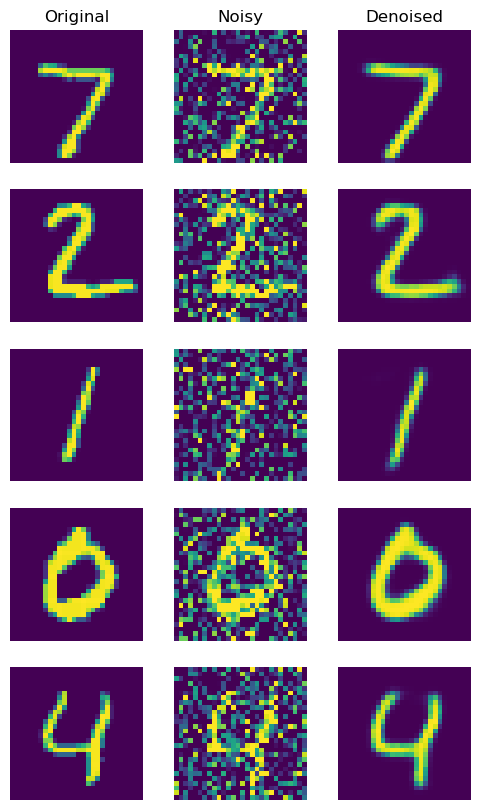

In [5]:
# Show the result of the encoder with the original, the noisy and the cleaned images

import numpy as np
import matplotlib.pyplot as plt

n_images = 5
new_images = x_test[:n_images]
new_images_noisy = x_test_noisy[:n_images]
new_images_denoised = autoencoder.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [6]:
# Classification model

# Define the classification DNN reusing the lower layers of the autoencoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

In [7]:
# Reuse the layers and not train them

# Create the classification model by stacking the encoder layers on top of the classification layers
classifier = Model(input_img, output)
for i in range(6):
    classifier.layers[i].set_weights(autoencoder.layers[i].get_weights())

# Freeze the weights of the encoder layers to prevent them from being updated during training
for layer in classifier.layers[:6]:
    layer.trainable = False

In [8]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

In [9]:
# Compile the classification model and train it on only 500 images from the training set
classifier.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

classifier.fit(x_train, y_train_cat,
               batch_size=128,
               epochs=20,
               verbose=1)

Epoch 1/20
469/469 [==============================] - 7s 14ms/step - loss: 0.1408 - accuracy: 0.9587
Epoch 2/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0606 - accuracy: 0.9805
Epoch 3/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0486 - accuracy: 0.9851
Epoch 4/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0407 - accuracy: 0.9865
Epoch 5/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0353 - accuracy: 0.9889
Epoch 6/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0333 - accuracy: 0.9893
Epoch 7/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0293 - accuracy: 0.9903
Epoch 8/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0262 - accuracy: 0.9914
Epoch 9/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0240 - accuracy: 0.9921
Epoch 10/20
469/469 [==============================] - 6s 14ms/step - loss: 0.0218 - accura

In [11]:
# Evaluate the performance of the classification model with and without pretraining
score = classifier.evaluate(x_test, y_test_cat, verbose=0)
print('Test loss without pretraining:', score[0])
print('Test accuracy without pretraining:', score[1])

Test loss without pretraining: 0.0542604923248291
Test accuracy without pretraining: 0.9858999848365784


In [14]:
# Classification model

# Define the classification DNN reusing the lower layers of the autoencoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

# Compile the classification model and train it on only 500 images from the training set
classifier.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

classifier.fit(x_train, y_train_cat,
               batch_size=128,
               epochs=20,
               verbose=1)

Epoch 1/20
469/469 [==============================] - 23s 47ms/step - loss: 0.0042 - accuracy: 0.9986
Epoch 2/20
469/469 [==============================] - 25s 54ms/step - loss: 0.0024 - accuracy: 0.9991
Epoch 3/20
469/469 [==============================] - 27s 57ms/step - loss: 0.0033 - accuracy: 0.9987
Epoch 4/20
469/469 [==============================] - 24s 51ms/step - loss: 5.4604e-04 - accuracy: 0.9999
Epoch 5/20
469/469 [==============================] - 26s 55ms/step - loss: 0.0029 - accuracy: 0.9991
Epoch 6/20
469/469 [==============================] - 21s 44ms/step - loss: 0.0044 - accuracy: 0.9987
Epoch 7/20
469/469 [==============================] - 21s 44ms/step - loss: 0.0032 - accuracy: 0.9989
Epoch 8/20
469/469 [==============================] - 21s 44ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 9/20
469/469 [==============================] - 21s 45ms/step - loss: 0.0028 - accuracy: 0.9991
Epoch 10/20
469/469 [==============================] - 21s 45ms/step - loss: 0

In [15]:
# Evaluate the performance of the classification model with and without pretraining
score = classifier.evaluate(x_test, y_test_cat, verbose=0)
print('Test loss without pretraining:', score[0])
print('Test accuracy without pretraining:', score[1])

Test loss without pretraining: 0.040475934743881226
Test accuracy without pretraining: 0.9933000206947327


In [ ]:
# The model with the trained layers from the encoder got: 98.59% accuracy
# The model completely trained from scratch got: 99.33 accuracy
# This shows, that it is not benefitial to use layers that are already trained for the purpose
# They simply add constraint to the model and dont allow it to train well enough
# Might be improable increasing the size of the model